# Fruit Classifier

The notebook demonstrates the use of a convolutional neural network to classify image data. All the necessary steps are presented and described in this notebook.

A Kaggle data set is used as data source, see https://www.kaggle.com/moltean/fruits/home

## Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pyprind
import time
from skimage.transform import resize as imresize

## Set constants

In [79]:
#Width and Height to resize the Images
image_height=10
image_width= 10

#Filename to save loaded images and labels
filename= 'test_data.npz'

#Dir where to load the images from
data_dir = './Data/Training'

## Load Images

In [80]:
dataset= np.load(file=filename)
labels=dataset['labels']
images=dataset['images']

print(images.shape)
print('load %d files' %len(labels))

(31688, 50, 50, 3)
load 31688 files


In [81]:
f = lambda x: np.max(labels) if np.min(labels) !=0 else np.max(labels)+1
classes = f(labels)
print(classes)

class_names = np.loadtxt('classNames.txt' , dtype=np.str, delimiter='\n' )
print(class_names)

64
['Apple Braeburn' 'Apple Golden 1' 'Apple Golden 2' 'Apple Golden 3'
 'Apple Granny Smith' 'Apple Red 1' 'Apple Red 2' 'Apple Red 3'
 'Apple Red Delicious' 'Apple Red Yellow' 'Apricot' 'Avocado'
 'Avocado ripe' 'Banana' 'Banana Red' 'Cactus fruit' 'Cantaloupe 1'
 'Cantaloupe 2' 'Carambula' 'Cherry 1' 'Cherry 2' 'Cherry Rainier'
 'Clementine' 'Cocos' 'Dates' 'Granadilla' 'Grape Pink' 'Grape White'
 'Grape White 2' 'Grapefruit Pink' 'Grapefruit White' 'Guava'
 'Huckleberry' 'Kaki' 'Kiwi' 'Kumquats' 'Lemon' 'Lemon Meyer' 'Limes'
 'Litchi' 'Mandarine' 'Mango' 'Maracuja' 'Nectarine' 'Orange' 'Papaya'
 'Passion Fruit' 'Peach' 'Peach Flat' 'Pear' 'Pear Abate' 'Pear Monster'
 'Pear Williams' 'Pepino' 'Pineapple' 'Pitahaya Red' 'Plum' 'Pomegranate'
 'Quince' 'Raspberry' 'Salak' 'Strawberry' 'Tamarillo' 'Tangelo']


64


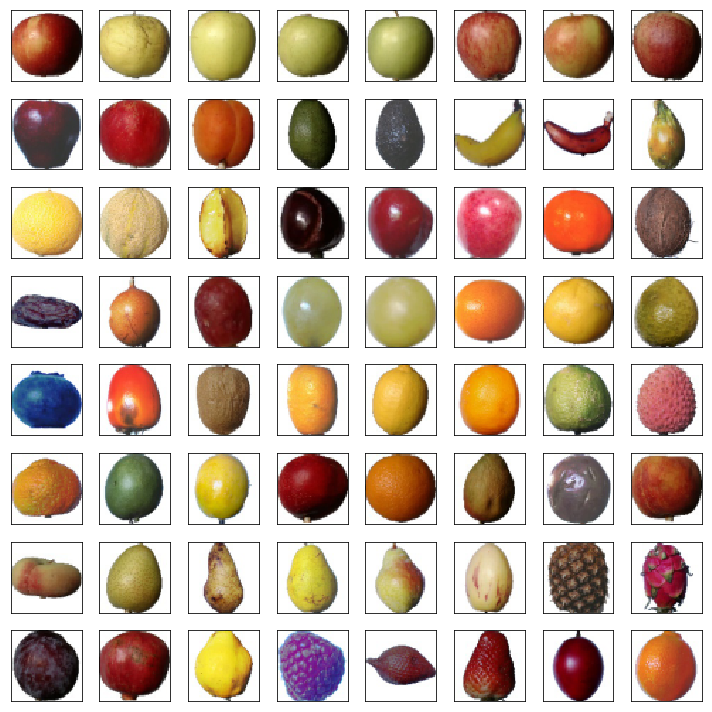

In [82]:
def plot_dataset(images, labels, img_x=image_height, img_y=image_width):

        images_to_show = np.empty((0, img_x, img_y, 3), dtype=np.uint8)
        for label in np.unique(labels):
            images_to_show = np.concatenate((images_to_show, images[labels == label][:1]), axis=0)
        print(len(images_to_show))      
        plot(images_to_show)
        

def plot(images_to_show, predictions= np.array([])):
        fig = plt.figure(figsize=(10,10))
        for i in range(len(images_to_show)):
            ax = fig.add_subplot(math.ceil(math.sqrt(len(images_to_show))), 
                                 math.ceil(math.sqrt(len(images_to_show))),
                                 1 + i, xticks=[], yticks=[])
            if predictions.size:
                predicted_class_name = class_names[int(predictions[i][1])]
                true_class_name = class_names[int(predictions[i][2])]
                ax.set_xlabel('%6.2f  \nPrediction: %s \n True Label: %s'
                    % (predictions[i][0], predicted_class_name, true_class_name), fontsize=12)
                
                      
            im = images_to_show[i]
            plt.imshow(im)

        plt.tight_layout()
        plt.show()

plot_dataset(images, labels, 50, 50)

In [83]:
def resize_images(images, img_x, img_y):
    bar = pyprind.ProgBar(len(images))
    data = np.empty((len(images), img_x, img_y, 3))
    for i, image in enumerate(images):
        
        data[i,...]  = imresize(image, (img_x, img_y, 3), mode = 'constant')
        
        bar.update()

    return data

print(images.shape)
images = resize_images(images, image_height, image_width)
print(images.shape)

(31688, 50, 50, 3)


c:\users\tsve\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:43


(31688, 10, 10, 3)


## Data Augmentation



3


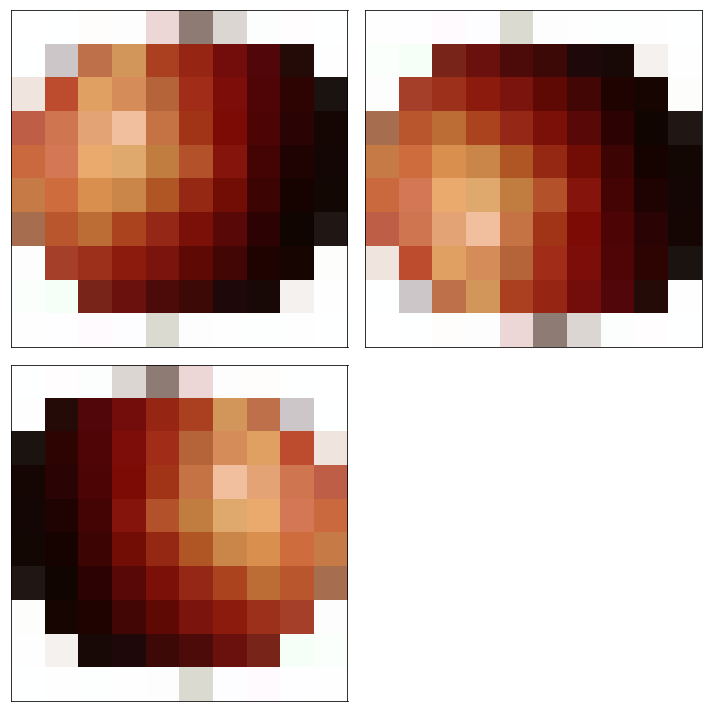

In [84]:
import cv2

img= images[0]

horizontal_flipt= cv2.flip(img, 0)
vertical_flipt= cv2.flip(img, 1)
#gray_scaled_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

augmented_images= [img, horizontal_flipt, vertical_flipt]
titels=['original', 'horizonzal', 'vertical']

print(len(augmented_images))
plot(augmented_images)

def randomize_images(images,labels):

    for index in range(len(images)):
        img = images[index]
        flipt_img= cv2.flip(img, np.random.randint(0,1))
        flipt_img = np.expand_dims(flipt_img, axis=0)
        images=np.vstack((images, flipt_img))
        labels = np.append(labels, np.asarray(labels[index]))
    print(len(images))
    return images, labels

## Train - Test - Validation


At the moment the image list is sorted, therefor its necessary to randomize this list. Otherwise the learning algorithm can not learn the features in a propper way. Thats why we shuffel the images and labels in the same way, so in every learning step there are diffrent class member.

In [85]:
from sklearn.utils import shuffle
images , labels = shuffle(images , labels, random_state=9)

In [86]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

length=len(labels)

X_train = images[:int(length*0.8)]
X_val   = images[int(length*0.8):int(length*0.9)]
X_test  = images[int(length*0.9):]
y_train = labels[:int(length*0.8)] 
y_val   = labels[int(length*0.8):int(length*0.9)]
y_test  = labels[int(length*0.9):]


y_train= np_utils.to_categorical(y_train, classes)
y_val = np_utils.to_categorical(y_val, classes)

print("Trainingsdaten:", X_train.shape)
print("Validierungsdaten:", X_val.shape)
print("Testdaten:", X_test.shape)

Trainingsdaten: (25350, 10, 10, 3)
Validierungsdaten: (3169, 10, 10, 3)
Testdaten: (3169, 10, 10, 3)


In [87]:
mean_values=np.mean(X_train, axis=0)
std_values=np.std(X_train)

x_train_centered= (X_train- mean_values)/std_values
x_val_centered= (X_val- mean_values)/std_values
x_test_centered= (X_test- mean_values)/std_values

## Convolutional Neural Network

In [88]:
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D,  BatchNormalization, Dropout, Flatten, Dense
from keras.optimizers import SGD

model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu',kernel_initializer='glorot_uniform', padding='same', 
                        input_shape=(image_height, image_width, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3),kernel_initializer='glorot_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64,kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy',  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 10, 10, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 5, 32)          128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
__________

In [93]:
from keras import callbacks
checkpointer = callbacks.ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)
earlyStopper = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

model.fit(x_train_centered[:5000], y_train[:5000],
          batch_size=100,
          epochs=10,
          validation_data=(x_val_centered[:500],  y_val[:500]),
          verbose=1
          )

Train on 5000 samples, validate on 500 samples
Epoch 1/10
5000/5000 [==============================] - 7s 1ms/step - loss: 1.9699 - acc: 0.5230 - val_loss: 1.8442 - val_acc: 0.6340
Epoch 2/10
5000/5000 [==============================] - 7s 1ms/step - loss: 1.6719 - acc: 0.5810 - val_loss: 1.5718 - val_acc: 0.6920
Epoch 3/10
5000/5000 [==============================] - 7s 1ms/step - loss: 1.4502 - acc: 0.6426 - val_loss: 1.3519 - val_acc: 0.7680
Epoch 4/10
5000/5000 [==============================] - 7s 1ms/step - loss: 1.2594 - acc: 0.6894 - val_loss: 1.1458 - val_acc: 0.7960
Epoch 5/10
5000/5000 [==============================] - 7s 1ms/step - loss: 1.1075 - acc: 0.7152 - val_loss: 0.9783 - val_acc: 0.8200
Epoch 6/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.9980 - acc: 0.7564 - val_loss: 0.8389 - val_acc: 0.8400
Epoch 7/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.9148 - acc: 0.7622 - val_loss: 0.7226 - val_acc: 0.8820
Epoch 8/10
5000

In [97]:
img_to_plot= X_test[:16]
predictions= model.predict(x_test_centered)[:16]

print(y_test)
prediction_array = []

for idx, pred in enumerate(predictions):
    prediction_array.append(np.array([pred[np.argmax(pred)], np.argmax(pred),y_test[idx]]))
    
prediction_array= np.array(prediction_array)    

true_labels=np_utils.to_categorical(y_test, classes)
metric= model.evaluate(x_test_centered, true_labels)

print('\n\nloss: %10.2f  \naccuracy: %6.2f' % (metric[0], metric[1]))

[ 3 16 48 ... 46 41 50]
[0.8265782 3.        3.       ]
3169/3169 [==============================] - 3s 877us/step


loss:       0.51  
accuracy:   0.91


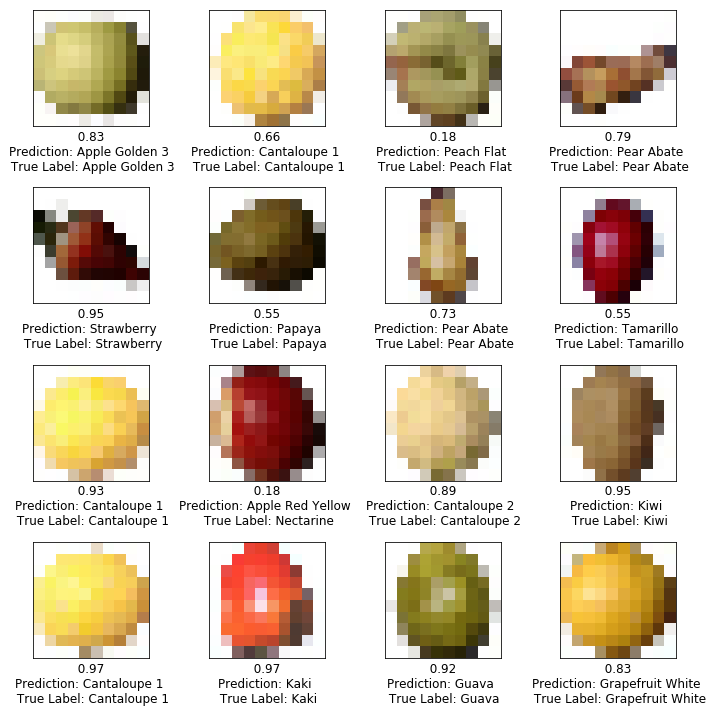

In [95]:
plot(img_to_plot,prediction_array )